In [1]:
# Process:
# Read in CSV of results as dataframe
# Clean up datatypes etc. Change names of teams blah blah
# Do some descriptive statistical analysis. Mean, standard deviation, some plots
# Goals scored/conceded looks a bit like a poisson. That makes sense. 
# Defn of poisson: 
# "a discrete frequency distribution which gives the probability of a 
# number of independent events occurring in a fixed time."
# I think goals for/against more or less fits this, although the independence assumption is probably shaky in reality
# Check with team, overlaying their all-time goal distribution against a theoretical one with lambda = average goals
# Then, build a model to try and predict future outcomes using poisson distribution
# The model takes a team's historical average goals scored and conceded against a given opponent, home and away
# Create function for goals scored by the home and away teams in a given match-up, with rates as above
# Uses this to simulate a score for the next game. Repeat it 100 times or so, and take the most common prediction,
# with the percentage of those 100 simulations it achieved being the confidence of the prediction.
# Some difficulties with teams that have never played each other – in this case use their historical averages
# And with newly promoted teams, that have never played in the premier legaue before. Take a historical average of all.
# The model works ok... not great. But football is a funny old game!

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# read in csv of historical results
results = pd.read_csv('results.csv')

In [3]:
# I would say the PL fundamentally changed when Abramovich bought Chelsea. At least in my memory that is when the 
# the money in the game started to become seriously excessive. Should we start the 'modern era' of EPL from 2003-04, 
# the season after Abramovich bought the blues?

# Define numerical columns for start and end of the season so we can compare dates more easily
results['season_start'] = results.Season.str[0:4].astype(int)
results['season_end'] = results['season_start'] + 1

modern_results = results[results.season_end >=1994]
modern_results.head()

modern_results[modern_results.HomeTeam == 'Leeds']
modern_results[modern_results.HomeTeam == 'Watford']

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HC,AC,HF,AF,HY,AY,HR,AR,season_start,season_end
2451,1999-00,1999-08-07T00:00:00Z,Watford,Wimbledon,2,3,A,1.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999,2000
2479,1999-00,1999-08-21T00:00:00Z,Watford,Bradford,1,0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999,2000
2484,1999-00,1999-08-24T00:00:00Z,Watford,Aston Villa,0,1,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999,2000
2515,1999-00,1999-09-18T00:00:00Z,Watford,Chelsea,1,0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999,2000
2537,1999-00,1999-10-03T00:00:00Z,Watford,Leeds,1,2,A,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10336,2019-20,2020-06-20T12:30:00Z,Watford,Leicester,1,1,D,0.0,0.0,D,...,2.0,7.0,15.0,12.0,0.0,1.0,0.0,0.0,2019,2020
10355,2019-20,2020-06-28T16:30:00Z,Watford,Southampton,1,3,A,0.0,1.0,A,...,5.0,3.0,18.0,9.0,3.0,0.0,0.0,0.0,2019,2020
10375,2019-20,2020-07-07T18:00:00Z,Watford,Norwich,2,1,H,1.0,1.0,D,...,4.0,3.0,11.0,15.0,2.0,4.0,0.0,0.0,2019,2020
10385,2019-20,2020-07-11T12:30:00Z,Watford,Newcastle,2,1,H,0.0,1.0,A,...,2.0,4.0,23.0,15.0,1.0,4.0,0.0,0.0,2019,2020


(536, 25)


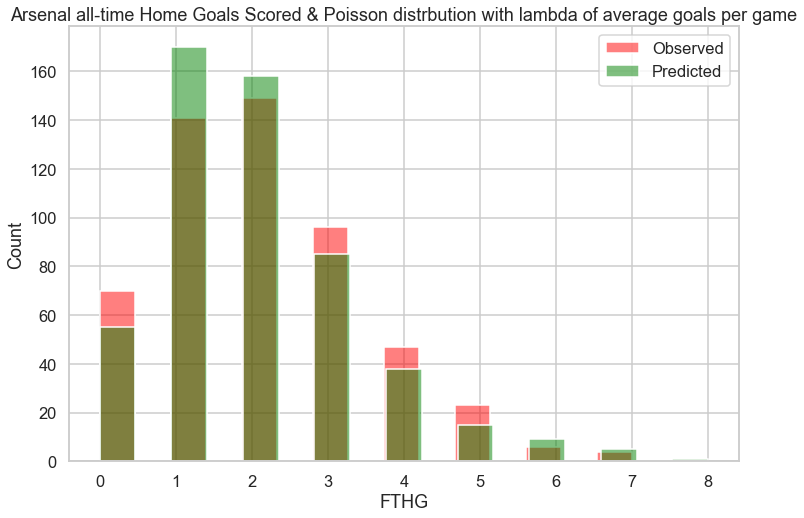

In [4]:
from scipy.stats import poisson

arsenal = modern_results[modern_results.HomeTeam == 'Arsenal']
print(arsenal.shape)

data_poisson = poisson.rvs(mu=arsenal.FTHG.mean(), size=536)

sns.set_style('whitegrid')
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(data=arsenal, x='FTHG', color='red', alpha = 0.5, ax = ax, label = 'Observed')
sns.histplot(data_poisson, kde=False, color='green', alpha = 0.5, ax = ax, label = 'Predicted')
ax.set_title('Arsenal all-time Home Goals Scored & Poisson distrbution with lambda of average goals per game')
ax.legend()


In [5]:
# Need to make a df of newly promoted teams. 
# Let's do the same group by as before for average scores, but group by season as well.

home_sav = results.groupby(
['HomeTeam', 'season_end']
).agg({'FTHG': 'mean', 'FTAG': 'mean'}).reset_index(
).sort_values(
    'season_end', ascending=False
)

home_sav = home_sav.rename(columns={'HomeTeam': 'team', 'FTHG':'home_goals_scored', 'FTAG': 'home_goals_conceded'})

away_sav = results.groupby(
['AwayTeam', 'season_end']
).agg({'FTAG': 'mean', 'FTHG': 'mean'}).reset_index(
).sort_values(
    'season_end', ascending=False
)

away_sav = away_sav.rename(columns={'AwayTeam': 'team', 'FTHG':'away_goals_conceded', 'FTAG': 'away_goals_scored'})

saverage = pd.merge(home_sav, away_sav, on=['team', 'season_end'])
saverage.head()

# Now that we have this, we need to find teams who drop out as we go back in time. I.e. were promoted this season.

,team,season_end,home_goals_scored,home_goals_conceded,away_goals_scored,away_goals_conceded
0,Liverpool,2021,1.526316,1.052632,2.052632,1.157895
1,Leicester,2021,1.789474,1.578947,1.789474,1.052632
2,Brighton,2021,1.157895,1.157895,0.947368,1.263158
3,Burnley,2021,0.736842,1.421053,1.000000,1.473684
4,Chelsea,2021,1.631579,0.947368,1.421053,0.947368


In [6]:
# Filter by season, then find the teams in that season, compare with the previous season
# Might be easiest to do this filtering in a function:

def season_filter(sea):
    return saverage[saverage.season_end == sea]

# Full list of season end years to iterate over
season_ends = list(results.season_end.unique())

# Empty dataframe of newly promoted seasons
newly_promoted = pd.DataFrame()

for season in season_ends:
    this_season = season_filter(season)
    last_season = season_filter(season - 1)
    for club in this_season.team.unique():
        if club not in last_season.team.unique():
            newly_promoted = newly_promoted.append(this_season[this_season.team == club])
            
display(newly_promoted)

av_np_hgs = newly_promoted.home_goals_scored.mean()
print(av_np_hgs)

av_np_hgc = newly_promoted.home_goals_conceded.mean()
print(av_np_hgc)

av_np_ags = newly_promoted.away_goals_scored.mean()
print(av_np_ags)

av_np_agc = newly_promoted.away_goals_conceded.mean()
print(av_np_agc)

,team,season_end,home_goals_scored,home_goals_conceded,away_goals_scored,away_goals_conceded
542,Southampton,1994,1.428571,1.476190,0.904762,1.666667
543,Man City,1994,1.142857,1.047619,0.666667,1.285714
544,Chelsea,1994,1.476190,0.952381,0.857143,1.571429
545,Swindon,1994,1.190476,2.142857,1.047619,2.619048
546,Coventry,1994,1.095238,0.809524,0.952381,1.333333
...,...,...,...,...,...,...
25,Aston Villa,2020,1.157895,1.578947,1.000000,1.947368
27,Norwich,2020,1.000000,1.947368,0.368421,2.000000
7,Fulham,2021,0.473684,1.473684,0.947368,1.315789
8,Leeds,2021,1.473684,1.105263,1.789474,1.736842


1.2689567054892132
1.3234802693007026
0.9688191065900043
1.7424689173915173


In [7]:
# inspect df – may have commented this shit out because it's annoying to look at

# print(results.describe())
# print(results.dtypes)
# print(results.shape)
# print(results.head())

# list(results.HomeTeam.unique())

In [8]:
# create all-time home and away averages dataframes

home_av = results.groupby(
['HomeTeam']
).agg({'FTHG': 'mean', 'FTAG': 'mean'}).reset_index(
).sort_values(
    'FTHG', ascending=False
)

home_av = home_av.rename(columns={'HomeTeam': 'team', 'FTHG':'home_goals_scored', 'FTAG': 'home_goals_conceded'})
home_av.head()

away_av = results.groupby(
['AwayTeam']
).agg({'FTAG': 'mean', 'FTHG': 'mean'}).reset_index(
).sort_values(
    'FTAG', ascending=False
)

away_av = away_av.rename(columns={'AwayTeam': 'team', 'FTHG':'away_goals_conceded', 'FTAG': 'away_goals_scored'})
away_av.head()

average = pd.merge(home_av, away_av, on='team')
average.head()

,team,home_goals_scored,home_goals_conceded,away_goals_scored,away_goals_conceded
0,Man United,2.132463,0.731343,1.712687,1.093284
1,Arsenal,2.041045,0.843284,1.533582,1.138060
2,Liverpool,1.988806,0.804104,1.490672,1.184701
3,Man City,1.970522,0.947846,1.437642,1.299320
4,Chelsea,1.968284,0.822761,1.475746,1.113806


In [9]:
# Create pairwise dataframe for results of head-to-head matches

# Probably don't want the whole df, because that would be a ridiculous amount of pairwise combinations, 
# so let's go with the modern results dataframe

pairwise_av = modern_results.groupby(
['HomeTeam', 'AwayTeam']).agg({'FTHG': 'mean', 'FTAG': 'mean'}).reset_index()

display(pairwise_av.head())

# Work out how many times teams have played each other

pairwise_counts = modern_results.groupby(['HomeTeam', 'AwayTeam']).size().reset_index(name="Count")

display(pairwise_counts.head())

# Merge the two dataframes so that we have the number of times in the same df as the home and away goals average
pairwise_history = pd.merge(pairwise_av, pairwise_counts, on=['HomeTeam', 'AwayTeam'])

display(pairwise_history.head(10))

,HomeTeam,AwayTeam,FTHG,FTAG
0,Arsenal,Aston Villa,2.000000,0.960000
1,Arsenal,Barnsley,5.000000,0.000000
2,Arsenal,Birmingham,1.714286,0.428571
3,Arsenal,Blackburn,2.352941,0.823529
4,Arsenal,Blackpool,6.000000,0.000000


,HomeTeam,AwayTeam,Count
0,Arsenal,Aston Villa,25
1,Arsenal,Barnsley,1
2,Arsenal,Birmingham,7
3,Arsenal,Blackburn,17
4,Arsenal,Blackpool,1


,HomeTeam,AwayTeam,FTHG,FTAG,Count
0,Arsenal,Aston Villa,2.000000,0.960000,25
1,Arsenal,Barnsley,5.000000,0.000000,1
2,Arsenal,Birmingham,1.714286,0.428571,7
3,Arsenal,Blackburn,2.352941,0.823529,17
4,Arsenal,Blackpool,6.000000,0.000000,1
5,Arsenal,Bolton,2.307692,0.923077,13
6,Arsenal,Bournemouth,2.800000,0.400000,5
7,Arsenal,Bradford,2.000000,0.000000,2
8,Arsenal,Brighton,1.500000,0.750000,4
9,Arsenal,Burnley,2.571429,0.714286,7


## GET SCORE FUNCTION

In [10]:
# We have called hist_pair: pairwise_av and pairwise_counts, one for the scores and one for the number of times teams
# have played against each other.

from collections import Counter

# Define a function taking the pair of teams we're concerned with, and the number of times we want to simulate games
# as arguments

def get_score(home, away, nsim):
    # create empty list of length nsim for scores to be input into
    scoreline = []
    
    # check both teams are in the dataset
    if (home in list(pairwise_history.HomeTeam.unique())) & (away in list(pairwise_history.AwayTeam.unique())):
        # find the two teams in our pairwise dataset
        subset = pairwise_history.loc[(pairwise_history.HomeTeam == home) & (pairwise_history.AwayTeam == away)]

        # but also find the average number of home and away goals scored and conceded in general by these teams
        t_home_scored_av = average.loc[average.team == home].home_goals_scored.values[0]
        t_away_conceded_av = average.loc[average.team == away].away_goals_conceded.values[0]
        t_home_conceded_av = average.loc[average.team == home].home_goals_conceded.values[0]
        t_away_scored_av = average.loc[average.team == away].away_goals_scored.values[0]

        # get the number of times the teams have played each other
        subcount = subset.Count.values

        # simulate the match nsim times
        for i in range(nsim):     
            # check the teams have played at least 4 times for a more reliable predicion:
            if subcount > 3:
                # find the average number of home and away goals scored per game in the pairings
                home_goals_av = subset.FTHG.values[0]
                away_goals_av = subset.FTAG.values[0]
                
                # Run Poisson process with rate 'average goals scored' for home and away in this specific pairing
                h_scored = np.random.poisson(home_goals_av)
                a_scored = np.random.poisson(away_goals_av)

            # if we have no historical result of the match, then we use the aggregate result
            else:
                # take into account both attacking stat of home and defense stats of away
                h_scored = np.random.poisson(0.5 * (t_home_scored_av + t_away_conceded_av))
                a_scored = np.random.poisson(0.5 * (t_home_conceded_av + t_away_scored_av))
                
            # append to scorelines list
            scoreline.append(str(h_scored) + ' - ' + str(a_scored))

    elif (home not in list(pairwise_history.HomeTeam.unique())) & (away in list(pairwise_history.AwayTeam.unique())):
        for i in range(nsim):     
            # if home team has never been in the prem before, we take their likely performance to be the average of all
            # newly promoted teams, and the away team worked out from their long-term average as before.

            t_away_conceded_av = average.loc[average.team == away].away_goals_conceded.values[0]
            t_away_scored_av = average.loc[average.team == away].away_goals_scored.values[0]

            # then do a poisson process taking each of these into account
            h_scored = np.random.poisson(0.5 * (av_np_hgs + t_away_conceded_av))
            a_scored = np.random.poisson(0.5 * (av_np_hgc + t_away_scored_av))

            # append to scorelines list
            scoreline.append(str(h_scored) + ' - ' + str(a_scored))
        
    elif (away not in list(pairwise_history.HomeTeam.unique())) & (home in list(pairwise_history.AwayTeam.unique())):
        for i in range(nsim):     
            # if away team has never been in the prem before, we take their likely performance to be the average of all
            # newly promoted teams, and the home team worked out from their long-term average as before.

            t_home_conceded_av = average.loc[average.team == home].home_goals_conceded.values[0]
            t_home_scored_av = average.loc[average.team == home].home_goals_scored.values[0]

            # then do a poisson process taking each of these into account
            h_scored = np.random.poisson(0.5 * (t_home_scored_av + av_np_agc))
            a_scored = np.random.poisson(0.5 * (t_home_conceded_av + av_np_ags))

            # append to scorelines list
            scoreline.append(str(h_scored) + ' - ' + str(a_scored))
        
    c = Counter(scoreline)
    # the function should return the most common scoreline and the number of times it occured
    
    return c.most_common(1)[0]
#     return scoreline
    

In [11]:
print(get_score('Arsenal', 'Aston Villa', 100))

('2 - 1', 12)


In [12]:
# Test the function. Try lots of different teams and different nsim numbers
print(get_score('Arsenal', 'Aston Villa', 100))
print(get_score('Man United', 'Man City', 100))

# It falls down on teams that have no premier league history... fixed!
print(get_score('Brentford', 'Chelsea', 100))
print(get_score('Brentford', 'Arsenal', 100))

# It now seems to be falling down on teams that have not played as many as 3 games
print(get_score('Watford', 'Aston Villa', 100))
print(get_score('Leeds', 'Man United', 100))

('1 - 0', 15)
('1 - 1', 16)
('1 - 1', 18)
('1 - 0', 12)
('2 - 0', 14)
('1 - 1', 14)


In [13]:
# Import fixtures from csv found online

# read in csv of results
fixtures = pd.read_csv('fixtures.csv')

fixtures.head()
fixtures['Home Team'].unique()

fixtures = fixtures.replace('Spurs','Tottenham')
fixtures = fixtures.replace('Man Utd','Man United')

display(fixtures['Home Team'].unique())


array(['Brentford', 'Man United', 'Burnley', 'Chelsea', 'Everton',
       'Leicester', 'Watford', 'Norwich', 'Newcastle', 'Tottenham',
       'Liverpool', 'Aston Villa', 'Crystal Palace', 'Leeds', 'Man City',
       'Brighton', 'Southampton', 'Wolves', 'Arsenal', 'West Ham'],
      dtype=object)

In [24]:
### Make some predictions for the first round of games

import warnings
warnings.filterwarnings('ignore')

round1 = fixtures[fixtures['Round Number'] == 1]

round1['Prediction'] = round1.apply(lambda x : get_score(x['Home Team'], x['Away Team'], 100), axis=1)

display(round1)

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result,Prediction
0,1,1,13/08/2021 20:00,Brentford Community Stadium,Brentford,Arsenal,2 - 0,"(1 - 1, 16)"
1,2,1,14/08/2021 12:30,Old Trafford,Man United,Leeds,5 - 1,"(2 - 1, 14)"
2,3,1,14/08/2021 15:00,Turf Moor,Burnley,Brighton,1 - 2,"(0 - 0, 21)"
3,4,1,14/08/2021 15:00,Stamford Bridge,Chelsea,Crystal Palace,3 - 0,"(1 - 0, 13)"
4,5,1,14/08/2021 15:00,Goodison Park,Everton,Southampton,3 - 1,"(1 - 0, 22)"
5,6,1,14/08/2021 15:00,King Power Stadium,Leicester,Wolves,1 - 0,"(0 - 0, 42)"
6,7,1,14/08/2021 15:00,Vicarage Road,Watford,Aston Villa,3 - 2,"(1 - 0, 18)"
7,8,1,14/08/2021 17:30,Carrow Road,Norwich,Liverpool,0 - 3,"(1 - 3, 11)"
8,9,1,15/08/2021 14:00,St. James' Park,Newcastle,West Ham,2 - 4,"(2 - 0, 15)"
9,10,1,15/08/2021 16:30,Tottenham Hotspur Stadium,Tottenham,Man City,1 - 0,"(2 - 1, 16)"


In [15]:
import re

round1['pred_score'] = round1['Prediction'].astype(str).str.extract("(\d+\s\-\s\d+)")
round1['pred_prob'] = round1['Prediction'].astype(str).str.extract("(\d+\))")
round1['pred_prob'] = round1['pred_prob'].str.strip(")").astype(int)
round1 = round1.drop('Prediction', axis=1)

display(round1)

<ipython-input-15-415151747657>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round1['pred_score'] = round1['Prediction'].astype(str).str.extract("(\d+\s\-\s\d+)")
<ipython-input-15-415151747657>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  round1['pred_prob'] = round1['Prediction'].astype(str).str.extract("(\d+\))")
<ipython-input-15-415151747657>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result,pred_score,pred_prob
0,1,1,13/08/2021 20:00,Brentford Community Stadium,Brentford,Arsenal,2 - 0,1 - 1,13
1,2,1,14/08/2021 12:30,Old Trafford,Man United,Leeds,5 - 1,1 - 0,19
2,3,1,14/08/2021 15:00,Turf Moor,Burnley,Brighton,1 - 2,0 - 0,21
3,4,1,14/08/2021 15:00,Stamford Bridge,Chelsea,Crystal Palace,3 - 0,3 - 0,12
4,5,1,14/08/2021 15:00,Goodison Park,Everton,Southampton,3 - 1,1 - 0,16
5,6,1,14/08/2021 15:00,King Power Stadium,Leicester,Wolves,1 - 0,0 - 0,48
6,7,1,14/08/2021 15:00,Vicarage Road,Watford,Aston Villa,3 - 2,1 - 1,18
7,8,1,14/08/2021 17:30,Carrow Road,Norwich,Liverpool,0 - 3,1 - 4,10
8,9,1,15/08/2021 14:00,St. James' Park,Newcastle,West Ham,2 - 4,1 - 1,11
9,10,1,15/08/2021 16:30,Tottenham Hotspur Stadium,Tottenham,Man City,1 - 0,0 - 1,16


In [16]:
# Make function to define winner of a match given a scoreline string
def winner(scoreline):
    scoreline = scoreline.split(' ')
    home_goals = scoreline[0]
    away_goals = scoreline[-1]
    if home_goals > away_goals:
        return 'Home Win'
    elif home_goals < away_goals:
        return 'Away Win'
    else:
        return 'Draw'    

In [17]:
round1['pred_result'] = round1.apply(lambda x: winner(x['pred_score']), axis=1)
round1['actual_result'] = round1.apply(lambda x: winner(x['Result']), axis=1)
round1['Correct'] = (round1.pred_result == round1['actual_result'])
round1

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result,pred_score,pred_prob,pred_result,actual_result,Correct
0,1,1,13/08/2021 20:00,Brentford Community Stadium,Brentford,Arsenal,2 - 0,1 - 1,13,Draw,Home Win,False
1,2,1,14/08/2021 12:30,Old Trafford,Man United,Leeds,5 - 1,1 - 0,19,Home Win,Home Win,True
2,3,1,14/08/2021 15:00,Turf Moor,Burnley,Brighton,1 - 2,0 - 0,21,Draw,Away Win,False
3,4,1,14/08/2021 15:00,Stamford Bridge,Chelsea,Crystal Palace,3 - 0,3 - 0,12,Home Win,Home Win,True
4,5,1,14/08/2021 15:00,Goodison Park,Everton,Southampton,3 - 1,1 - 0,16,Home Win,Home Win,True
5,6,1,14/08/2021 15:00,King Power Stadium,Leicester,Wolves,1 - 0,0 - 0,48,Draw,Home Win,False
6,7,1,14/08/2021 15:00,Vicarage Road,Watford,Aston Villa,3 - 2,1 - 1,18,Draw,Home Win,False
7,8,1,14/08/2021 17:30,Carrow Road,Norwich,Liverpool,0 - 3,1 - 4,10,Away Win,Away Win,True
8,9,1,15/08/2021 14:00,St. James' Park,Newcastle,West Ham,2 - 4,1 - 1,11,Draw,Away Win,False
9,10,1,15/08/2021 16:30,Tottenham Hotspur Stadium,Tottenham,Man City,1 - 0,0 - 1,16,Away Win,Home Win,False


In [22]:
round1_9 = fixtures[fixtures['Round Number'] <= 9]
round1_9['Prediction'] = round1_9.apply(lambda x : get_score(x['Home Team'], x['Away Team'], 100), axis=1)
round1_9

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result,Prediction
0,1,1,13/08/2021 20:00,Brentford Community Stadium,Brentford,Arsenal,2 - 0,"(1 - 1, 12)"
1,2,1,14/08/2021 12:30,Old Trafford,Man United,Leeds,5 - 1,"(1 - 0, 18)"
2,3,1,14/08/2021 15:00,Turf Moor,Burnley,Brighton,1 - 2,"(1 - 1, 20)"
3,4,1,14/08/2021 15:00,Stamford Bridge,Chelsea,Crystal Palace,3 - 0,"(2 - 1, 14)"
4,5,1,14/08/2021 15:00,Goodison Park,Everton,Southampton,3 - 1,"(2 - 0, 14)"
...,...,...,...,...,...,...,...,...
85,89,9,23/10/2021 15:00,St. Mary's Stadium,Southampton,Burnley,2 - 2,"(0 - 1, 13)"
86,83,9,23/10/2021 17:30,Amex Stadium,Brighton,Man City,1 - 4,"(2 - 3, 10)"
87,82,9,24/10/2021 14:00,Brentford Community Stadium,Brentford,Leicester,1 - 2,"(1 - 1, 13)"
88,90,9,24/10/2021 14:00,London Stadium,West Ham,Tottenham,1 - 0,"(1 - 2, 12)"


In [23]:
# Do some stuff to put in the prediction in a nice format

round1_9['pred_score'] = round1_9['Prediction'].astype(str).str.extract("(\d+\s\-\s\d+)")
round1_9['pred_prob'] = round1_9['Prediction'].astype(str).str.extract("(\d+\))")
round1_9['pred_prob'] = round1_9['pred_prob'].str.strip(")").astype(int)
round1_9 = round1_9.drop('Prediction', axis=1)

display(round1_9)

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result,pred_score,pred_prob
0,1,1,13/08/2021 20:00,Brentford Community Stadium,Brentford,Arsenal,2 - 0,1 - 1,12
1,2,1,14/08/2021 12:30,Old Trafford,Man United,Leeds,5 - 1,1 - 0,18
2,3,1,14/08/2021 15:00,Turf Moor,Burnley,Brighton,1 - 2,1 - 1,20
3,4,1,14/08/2021 15:00,Stamford Bridge,Chelsea,Crystal Palace,3 - 0,2 - 1,14
4,5,1,14/08/2021 15:00,Goodison Park,Everton,Southampton,3 - 1,2 - 0,14
...,...,...,...,...,...,...,...,...,...
85,89,9,23/10/2021 15:00,St. Mary's Stadium,Southampton,Burnley,2 - 2,0 - 1,13
86,83,9,23/10/2021 17:30,Amex Stadium,Brighton,Man City,1 - 4,2 - 3,10
87,82,9,24/10/2021 14:00,Brentford Community Stadium,Brentford,Leicester,1 - 2,1 - 1,13
88,90,9,24/10/2021 14:00,London Stadium,West Ham,Tottenham,1 - 0,1 - 2,12


In [20]:
# Some more stuff
round1_9['pred_result'] = round1_9.apply(lambda x: winner(x['pred_score']), axis=1)
round1_9['actual_result'] = round1_9.apply(lambda x: winner(x['Result']), axis=1)
round1_9['Correct'] = (round1_9.pred_result == round1_9['actual_result'])
round1_9

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result,pred_score,pred_prob,pred_result,actual_result,Correct
0,1,1,13/08/2021 20:00,Brentford Community Stadium,Brentford,Arsenal,2 - 0,0 - 1,14,Away Win,Home Win,False
1,2,1,14/08/2021 12:30,Old Trafford,Man United,Leeds,5 - 1,1 - 0,20,Home Win,Home Win,True
2,3,1,14/08/2021 15:00,Turf Moor,Burnley,Brighton,1 - 2,0 - 0,25,Draw,Away Win,False
3,4,1,14/08/2021 15:00,Stamford Bridge,Chelsea,Crystal Palace,3 - 0,1 - 1,11,Draw,Home Win,False
4,5,1,14/08/2021 15:00,Goodison Park,Everton,Southampton,3 - 1,1 - 0,19,Home Win,Home Win,True
...,...,...,...,...,...,...,...,...,...,...,...,...
85,89,9,23/10/2021 15:00,St. Mary's Stadium,Southampton,Burnley,2 - 2,2 - 0,15,Home Win,Draw,False
86,83,9,23/10/2021 17:30,Amex Stadium,Brighton,Man City,1 - 4,0 - 3,11,Away Win,Away Win,True
87,82,9,24/10/2021 14:00,Brentford Community Stadium,Brentford,Leicester,1 - 2,1 - 1,11,Draw,Away Win,False
88,90,9,24/10/2021 14:00,London Stadium,West Ham,Tottenham,1 - 0,1 - 0,16,Home Win,Home Win,True


In [21]:
round1_9.Correct.sum()

37